In [1]:
!python -V

Python 3.8.5


In [2]:
!pip install pyarrow --quiet

In [3]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error


In [5]:
df = pd.read_parquet("/home/bijay/data/fhv_tripdata_2021-01.parquet")

In [6]:
df

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037
...,...,...,...,...,...,...,...
1154107,B03266,2021-01-31 23:43:03,2021-01-31 23:51:48,7.0,7.0,None,B03266
1154108,B03284,2021-01-31 23:50:27,2021-02-01 00:48:03,44.0,91.0,None,
1154109,B03285,2021-01-31 23:13:46,2021-01-31 23:29:58,171.0,171.0,None,B03285
1154110,B03285,2021-01-31 23:58:03,2021-02-01 00:17:29,15.0,15.0,None,B03285


There are 1154112 records for January.

In [7]:
df.dtypes

dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                     float64
DOlocationID                     float64
SR_Flag                           object
Affiliated_base_number            object
dtype: object

In [8]:
df['duration'] = df.dropOff_datetime - df.pickup_datetime
df.duration = df.duration.apply(lambda d: d.total_seconds()/60)


In [9]:
avg_duration = df["duration"].mean()

In [10]:
avg_duration

19.1672240937939

The average trip duration in January is 19.16 mins.

In [11]:
df.describe()

,PUlocationID,DOlocationID,duration
count,195845.000000,991892.000000,1.154112e+06
mean,139.859690,135.898030,1.916722e+01
std,74.991382,80.474902,3.986922e+02
min,1.000000,1.000000,1.666667e-02
25%,75.000000,67.000000,7.766667e+00
50%,143.000000,132.000000,1.340000e+01
75%,206.000000,213.000000,2.228333e+01
max,265.000000,265.000000,4.233710e+05


In [12]:
df["duration"].max()

423371.05

Looks like there are some outliers in the `duration` column, as the max value is 423371.05 mins. So we'll keep only the records with duration between 1 to 60 minutes (inclusive).

In [13]:
df = df[(df.duration >= 1) & (df.duration <= 60)] # filter out rows with duration less than 1min and greater than 60min

categorical = ["PUlocationID", "DOlocationID"]

df[categorical] = df[categorical].astype(str)

/home/bijay/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [14]:
df.shape

(1109826, 8)

44,286 records were dropped.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1109826 entries, 0 to 1154111
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1109826 non-null  object        
 1   pickup_datetime         1109826 non-null  datetime64[ns]
 2   dropOff_datetime        1109826 non-null  datetime64[ns]
 3   PUlocationID            1109826 non-null  object        
 4   DOlocationID            1109826 non-null  object        
 5   SR_Flag                 0 non-null        object        
 6   Affiliated_base_number  1109053 non-null  object        
 7   duration                1109826 non-null  float64       
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 76.2+ MB


In [16]:
df["PUlocationID"].isnull().sum()

0

In [17]:
df["DOlocationID"].isnull().sum()

0

In [19]:
df["PUlocationID"].value_counts()

nan      927008
221.0      8330
206.0      6797
129.0      5379
115.0      4082
          ...  
111.0         5
27.0          4
34.0          3
2.0           2
110.0         1
Name: PUlocationID, Length: 262, dtype: int64

In [20]:
df["DOlocationID"].value_counts()

nan      147907
76.0      26375
217.0     19488
265.0     18628
17.0      18422
          ...  
27.0         18
30.0         13
2.0          11
105.0         4
199.0         1
Name: DOlocationID, Length: 263, dtype: int64

There are 147907 nan values in `DOlocationID` and 927008 in `PUlocationID`.

In [23]:
df["DOlocationID"] = df["DOlocationID"].apply(lambda x: -1 if x == "nan" else x)
df["PUlocationID"] = df["PUlocationID"].apply(lambda x: -1 if x == "nan" else x)

<ipython-input-23-d218a56b115d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["DOlocationID"] = df["DOlocationID"].apply(lambda x: -1 if x == "nan" else x)
<ipython-input-23-d218a56b115d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["PUlocationID"] = df["PUlocationID"].apply(lambda x: -1 if x == "nan" else x)


In [24]:
df["DOlocationID"].value_counts()

-1       147907
76.0      26375
217.0     19488
265.0     18628
17.0      18422
          ...  
27.0         18
30.0         13
2.0          11
105.0         4
199.0         1
Name: DOlocationID, Length: 263, dtype: int64

In [25]:
fraction = (927008/1109826)*100
fraction

83.52732770722618

The fraction of missing values for the `PUlocationID` is 83%.

In [26]:
# we are using only two features for our model
# PUlocationID and DOlocationID
train_dicts =df[categorical].to_dict(orient="records")

In [27]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [36]:
len(dv.feature_names_)

525

The dimensionality of feature matrix is 525.

Each location ID becomes a feature.

In [31]:
targets = "duration"
y_train = df[targets].values

In [32]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [33]:
y_pred =lr.predict(X_train)

/home/bijay/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/bijay/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


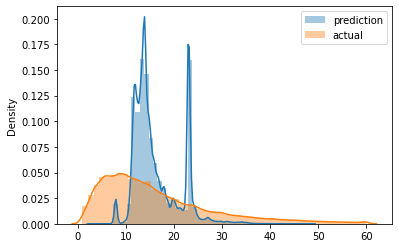

In [35]:
sns.distplot(y_pred, label="prediction")
sns.distplot(y_train, label="actual")

plt.legend();

In [37]:
mean_squared_error(y_train, y_pred, squared=False)

10.528519107206316

The RMSE on train is 10.52.

In [49]:
def read_df(file_name):
    df = pd.read_parquet(f"/home/bijay/data/{file_name}")
    df['duration'] = df.dropOff_datetime - df.pickup_datetime
    df.duration = df.duration.apply(lambda d: d.total_seconds()/60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    categorical = ["PUlocationID", "DOlocationID"]
    df[categorical] = df[categorical].astype(str)
    df["DOlocationID"] = df["DOlocationID"].apply(lambda x: -1 if x == "nan" else x)
    df["PUlocationID"] = df["PUlocationID"].apply(lambda x: -1 if x == "nan" else x)
    return df
    

In [50]:
df_train = read_df("fhv_tripdata_2021-01.parquet")
df_val = read_df("fhv_tripdata_2021-02.parquet")

In [51]:
categorical = ["PUlocationID", "DOlocationID"]

dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient="records")
X_train =dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient="records")
X_val = dv.transform(val_dicts)

In [53]:
target = "duration"
y_train = df_train[target].values
y_val = df_val[target].values

In [54]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
y_val_pred = lr.predict(X_val)

In [55]:
train_rmse = mean_squared_error(y_train, y_pred, squared=False)
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)

In [56]:
train_rmse, val_rmse

(10.528519107206316, 11.014283149347039)

The train RMSE is 10.52 and validation RMSE is 11.01 (on Feb 2021 dataset).